In [1]:
!pip install -q kaggle timm torchvision scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.3 MB/s eta 0:00:00


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [3]:
!kaggle datasets download -d stepanyarullin/interior-design-styles
!unzip -q interior-design-styles.zip -d ./interior_styles

Dataset URL: https://www.kaggle.com/datasets/stepanyarullin/interior-design-styles
License(s): MIT


In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

data_dir = './interior_styles'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'dataset_train/dataset_train'), data_transforms['train'])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'dataset_test/dataset_test'), data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Классы: {train_dataset.classes}")


Классы: ['asian', 'coastal', 'contemporary', 'craftsman', 'eclectic', 'farmhouse', 'french-country', 'industrial', 'mediterranean', 'mid-century-modern', 'modern', 'rustic', 'scandinavian', 'shabby-chic-style', 'southwestern', 'traditional', 'transitional', 'tropical', 'victorian']


## ResNet18 baseline

Загружаем ResNet. Меняем последний слой под наши количество классов

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.1MB/s]


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [16]:
for epoch in range(100):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch%10 == 0:
      print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 423.6602
Epoch 11: Loss = 39.5578
Epoch 21: Loss = 30.5673
Epoch 31: Loss = 29.4333


KeyboardInterrupt: 

ResNet18 Accuracy: 0.3019576293912577
ResNet18 F1 Score (macro): 0.29743618769972013


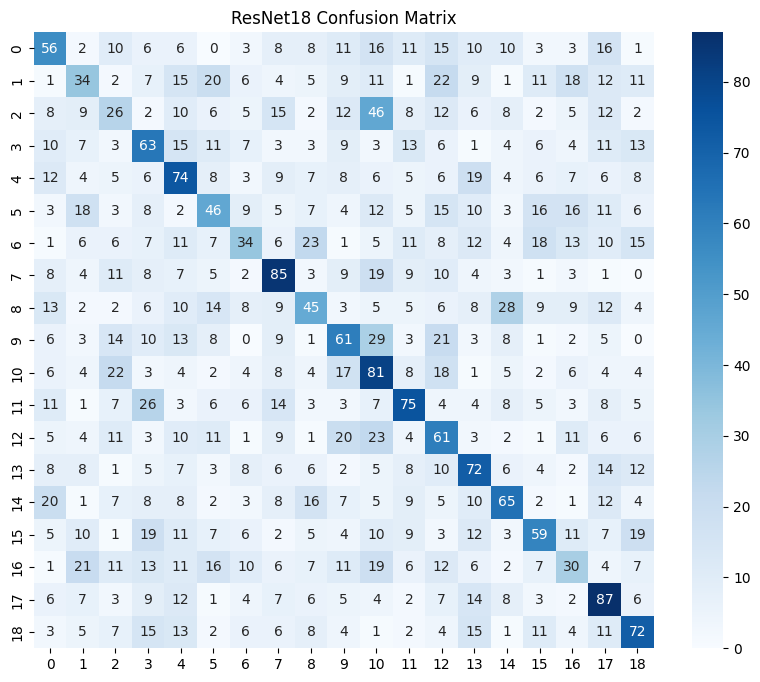

In [23]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("ResNet18 Accuracy:", accuracy_score(all_labels, all_preds))
print("ResNet18 F1 Score (macro):", f1_score(all_labels, all_preds, average='macro'))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, cmap='Blues')
plt.title("ResNet18 Confusion Matrix")
plt.show()


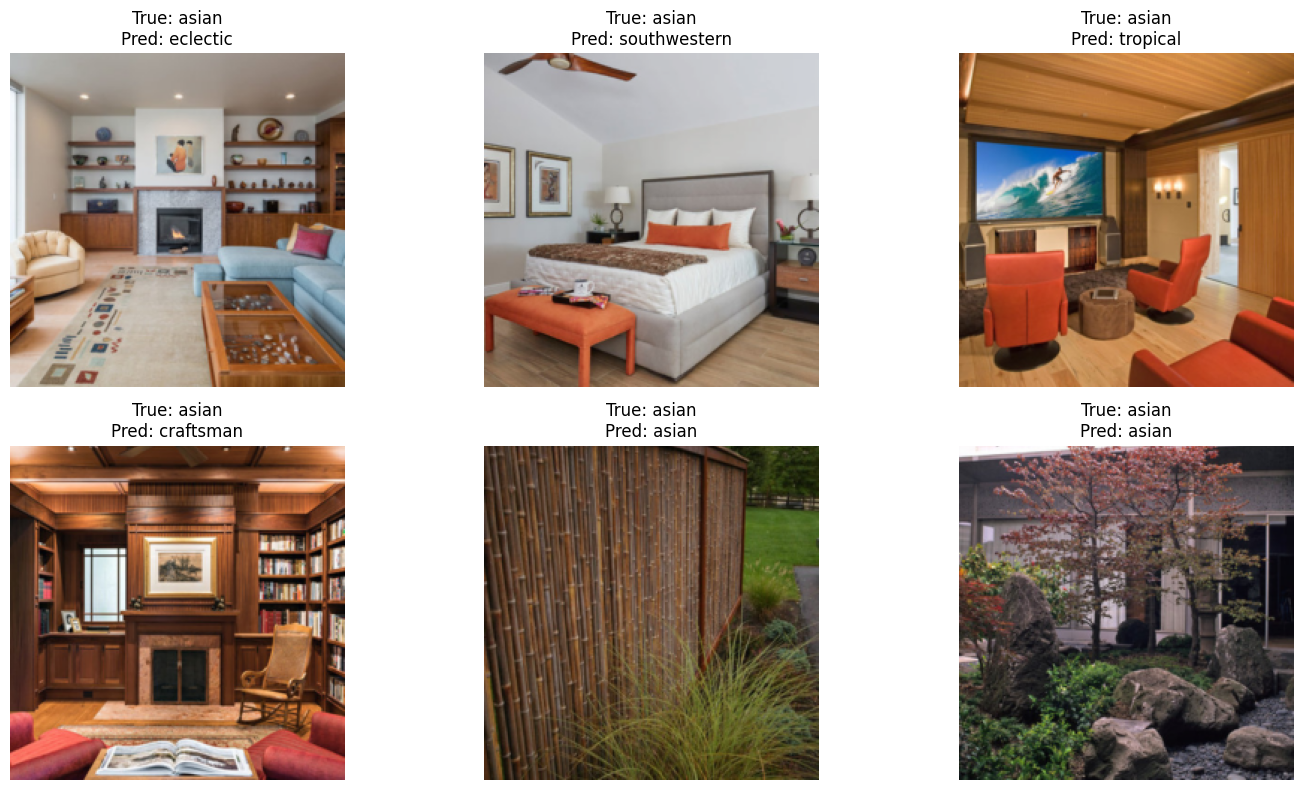

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    return np.clip(img, 0, 1)

model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(imshow(images[i+5].cpu()))
    plt.title(f"True: {train_dataset.classes[labels[i+5]]}\nPred: {train_dataset.classes[preds[i+5]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## ViT baseline

In [24]:
from timm import create_model

# Создание модели ViT-B/16
vit_model = create_model('vit_base_patch16_224', pretrained=True, num_classes=len(train_dataset.classes))
vit_model = vit_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [25]:
for epoch in range(10):
    vit_model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vit_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: ViT Loss = {total_loss:.4f}")


Epoch 1: ViT Loss = 1265.9368
Epoch 2: ViT Loss = 1069.0820
Epoch 3: ViT Loss = 906.3544
Epoch 4: ViT Loss = 697.8899
Epoch 5: ViT Loss = 469.4127
Epoch 6: ViT Loss = 272.6189
Epoch 7: ViT Loss = 170.2087
Epoch 8: ViT Loss = 116.0847
Epoch 9: ViT Loss = 90.6948
Epoch 10: ViT Loss = 90.1510


ViT Accuracy: 0.3027621346205417
ViT F1 Score (macro): 0.2961032181188662


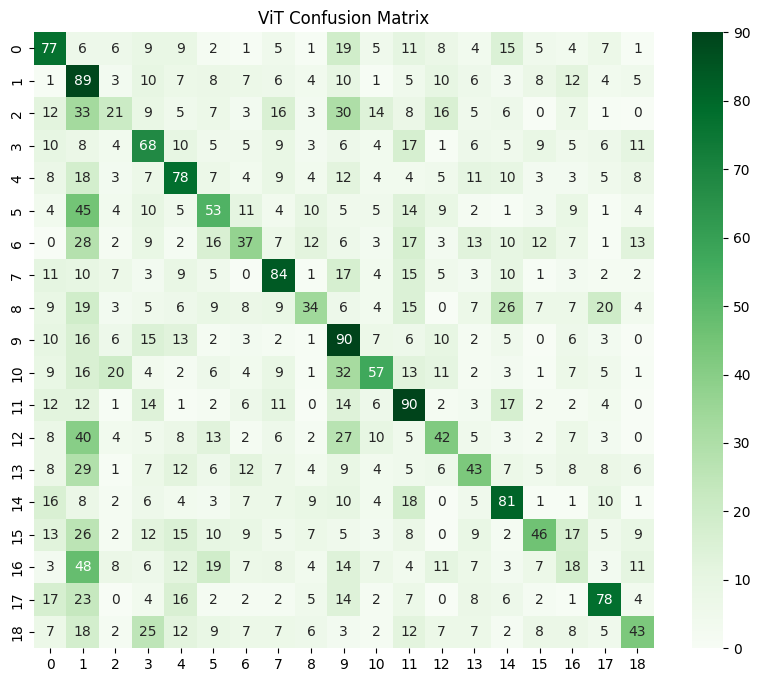

In [30]:
vit_model.eval()
vit_preds, vit_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = vit_model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        vit_preds.extend(preds)
        vit_labels.extend(labels.numpy())

print("ViT Accuracy:", accuracy_score(vit_labels, vit_preds))
print("ViT F1 Score (macro):", f1_score(vit_labels, vit_preds, average='macro'))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(vit_labels, vit_preds), annot=True, cmap='Greens')
plt.title("ViT Confusion Matrix")
plt.show()


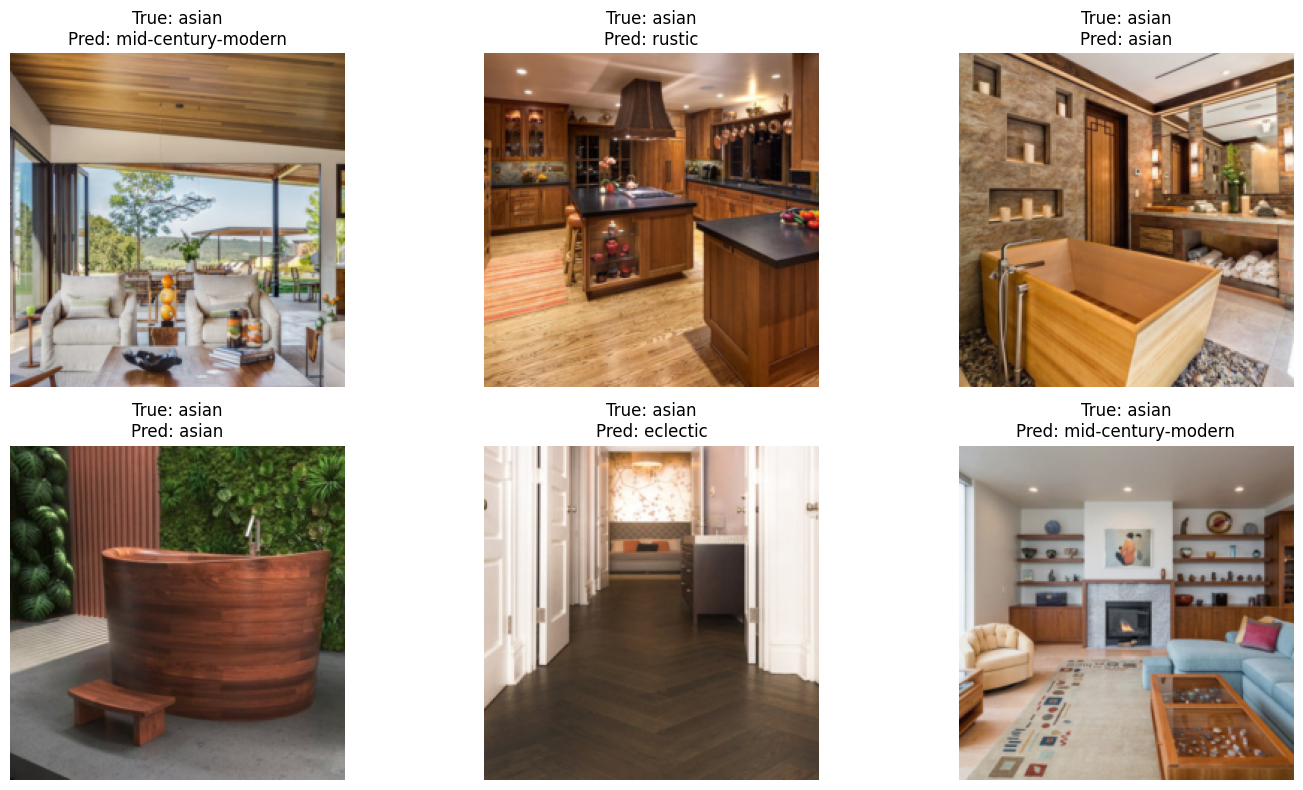

In [27]:
# Примеры предсказаний ViT
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = vit_model(images)
    preds = torch.argmax(outputs, dim=1)

plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(imshow(images[i].cpu()))
    plt.title(f"True: {train_dataset.classes[labels[i]]}\nPred: {train_dataset.classes[preds[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Собственная реализация классификатора

- **Сверточные слои (`conv1`, `conv2`)**  
  Извлекают признаки из входных изображений. Используют ядро 3×3 и сохраняют размер за счёт паддинга.

- **Слоев подвыборки (`pool1`, `pool2`)**  
  `MaxPool2d` уменьшает пространственное разрешение карт признаков, что снижает вычислительную нагрузку и делает признаки более инвариантными к сдвигам.

- **Полносвязные слои (`fc1`, `fc2`)**  
  После свёрток и пулинга данные «разворачиваются» в вектор, который проходит через два линейных слоя. Последний слой имеет размерность, равную числу классов (для классификации).

- **Активация**  
  Обычно после каждого слоя используется `ReLU`, чтобы добавить нелинейность (в коде не указано, но применяется в `forward()`).


In [28]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


## SimpleCNN baseline

In [31]:
simple_model = SimpleCNN(num_classes=len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_model.parameters(), lr=1e-4)

for epoch in range(20):
    simple_model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = simple_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[SimpleCNN] Epoch {epoch+1}: Loss = {total_loss:.4f}")


[SimpleCNN] Epoch 1: Loss = 1327.4698
[SimpleCNN] Epoch 2: Loss = 1283.6870
[SimpleCNN] Epoch 3: Loss = 1249.7383
[SimpleCNN] Epoch 4: Loss = 1216.6136
[SimpleCNN] Epoch 5: Loss = 1178.1990
[SimpleCNN] Epoch 6: Loss = 1129.3197
[SimpleCNN] Epoch 7: Loss = 1075.5580
[SimpleCNN] Epoch 8: Loss = 1007.9712
[SimpleCNN] Epoch 9: Loss = 940.2918
[SimpleCNN] Epoch 10: Loss = 865.4758
[SimpleCNN] Epoch 11: Loss = 785.2934
[SimpleCNN] Epoch 12: Loss = 715.8064
[SimpleCNN] Epoch 13: Loss = 633.2100
[SimpleCNN] Epoch 14: Loss = 564.6053
[SimpleCNN] Epoch 15: Loss = 496.8734
[SimpleCNN] Epoch 16: Loss = 441.3712
[SimpleCNN] Epoch 17: Loss = 392.0794
[SimpleCNN] Epoch 18: Loss = 354.5717
[SimpleCNN] Epoch 19: Loss = 318.8496
[SimpleCNN] Epoch 20: Loss = 281.0837


SimpleCNN Accuracy: 0.17940466613032985
SimpleCNN F1 Score (macro): 0.18032211152349412


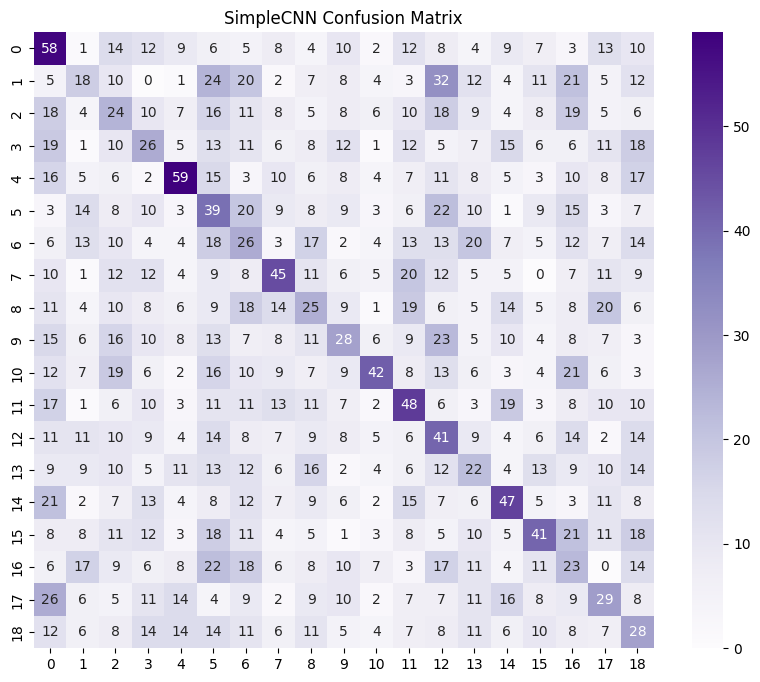

In [39]:
simple_model.eval()
simple_preds, simple_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = simple_model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        simple_preds.extend(preds)
        simple_labels.extend(labels.numpy())

print("SimpleCNN Accuracy:", accuracy_score(simple_labels, simple_preds))
print("SimpleCNN F1 Score (macro):", f1_score(simple_labels, simple_preds, average='macro'))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(simple_labels, simple_preds), annot=True, cmap='Purples')
plt.title("SimpleCNN Confusion Matrix")
plt.show()


## Улучшенный бейзлайн

Для повышения устойчивости модели к различным искажениям и увеличения разнообразия обучающего датасета была применена аугментация изображений. Использовались следующие преобразования:

- изменение размера изображений до 224×224 пикселей;
- случайное горизонтальное отражение;
- случайный поворот до ±10 градусов;
- изменение яркости, контраста и насыщенности (ColorJitter);
- случайный аффинный сдвиг изображения по ширине и высоте;
- нормализация каналов изображения.

In [33]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ])
}

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'dataset_train/dataset_train'), data_transforms['train'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



Resnet18

In [34]:
model_upd = model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_upd.parameters(), lr=1e-4)

In [35]:
for epoch in range(20):
    model_upd.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_upd(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch%10 == 0:
      print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 641.3254
Epoch 11: Loss = 119.1167


ResNet18 Accuracy: 0.31187986055242695
ResNet18 F1 Score (macro): 0.31112413660635063


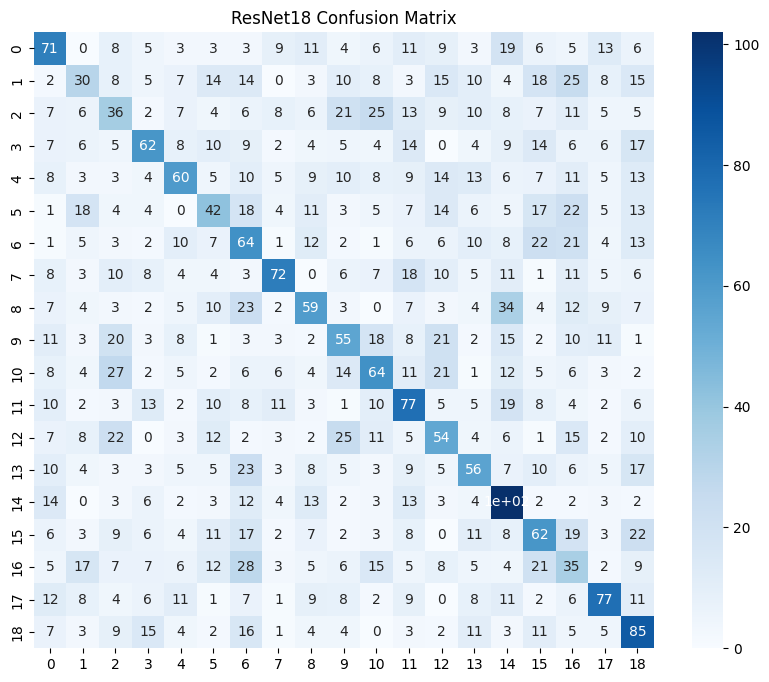

In [36]:
model_upd.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_upd(images)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("ResNet18 Accuracy:", accuracy_score(all_labels, all_preds))
print("ResNet18 F1 Score (macro):", f1_score(all_labels, all_preds, average='macro'))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, cmap='Blues')
plt.title("ResNet18 Confusion Matrix")
plt.show()


ViT

In [37]:
for epoch in range(5):
    vit_model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vit_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: ViT Loss = {total_loss:.4f}")


Epoch 1: ViT Loss = 840.4966
Epoch 2: ViT Loss = 839.6835
Epoch 3: ViT Loss = 837.2135
Epoch 4: ViT Loss = 842.8601
Epoch 5: ViT Loss = 840.8898


ViT Accuracy: 0.3027621346205417
ViT F1 Score (macro): 0.2961032181188662


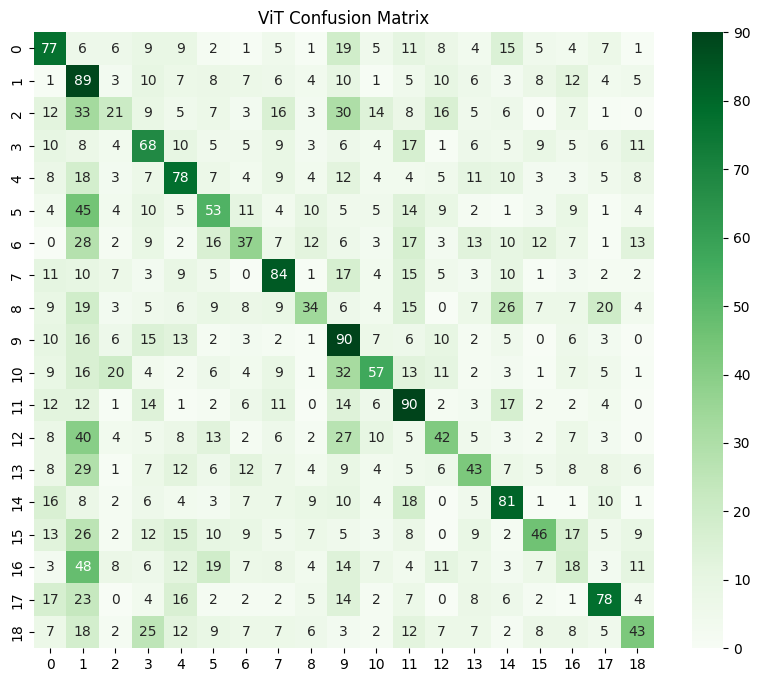

In [38]:
vit_model.eval()
vit_preds, vit_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = vit_model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        vit_preds.extend(preds)
        vit_labels.extend(labels.numpy())

print("ViT Accuracy:", accuracy_score(vit_labels, vit_preds))
print("ViT F1 Score (macro):", f1_score(vit_labels, vit_preds, average='macro'))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(vit_labels, vit_preds), annot=True, cmap='Greens')
plt.title("ViT Confusion Matrix")
plt.show()


Собственная имплементация

In [40]:
simple_model = SimpleCNN(num_classes=len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_model.parameters(), lr=1e-4)

for epoch in range(20):
    simple_model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = simple_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[SimpleCNN] Epoch {epoch+1}: Loss = {total_loss:.4f}")


[SimpleCNN] Epoch 1: Loss = 1343.1921
[SimpleCNN] Epoch 2: Loss = 1319.1562
[SimpleCNN] Epoch 3: Loss = 1307.0617
[SimpleCNN] Epoch 4: Loss = 1294.3595
[SimpleCNN] Epoch 5: Loss = 1283.8219
[SimpleCNN] Epoch 6: Loss = 1275.2949
[SimpleCNN] Epoch 7: Loss = 1266.9726
[SimpleCNN] Epoch 8: Loss = 1261.9940
[SimpleCNN] Epoch 9: Loss = 1252.4211
[SimpleCNN] Epoch 10: Loss = 1243.8346
[SimpleCNN] Epoch 11: Loss = 1240.4877
[SimpleCNN] Epoch 12: Loss = 1234.2468
[SimpleCNN] Epoch 13: Loss = 1226.8763
[SimpleCNN] Epoch 14: Loss = 1221.7866
[SimpleCNN] Epoch 15: Loss = 1214.0143
[SimpleCNN] Epoch 16: Loss = 1211.2678
[SimpleCNN] Epoch 17: Loss = 1204.5814
[SimpleCNN] Epoch 18: Loss = 1201.4424
[SimpleCNN] Epoch 19: Loss = 1195.4800
[SimpleCNN] Epoch 20: Loss = 1192.0217


SimpleCNN Accuracy: 0.22150710646285868
SimpleCNN F1 Score (macro): 0.20770928938995495


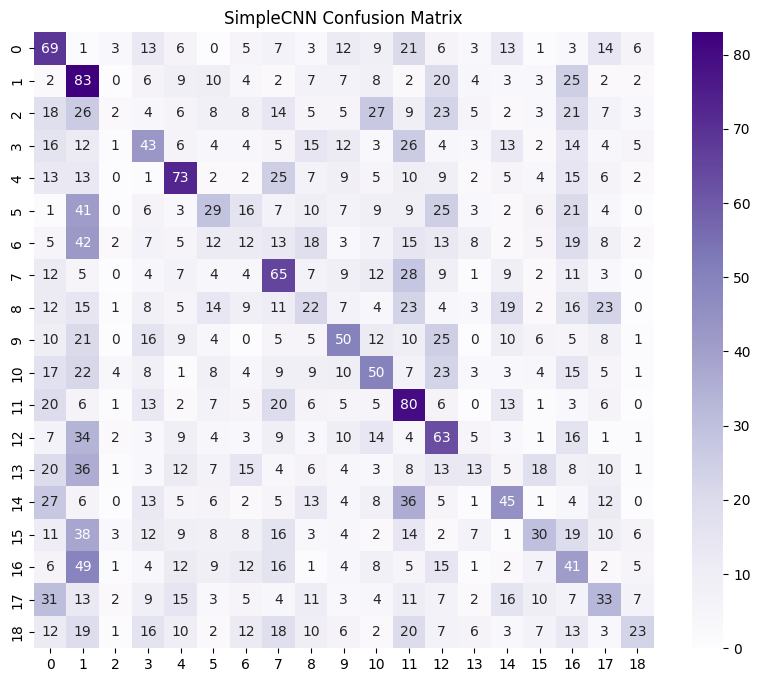

In [41]:
simple_model.eval()
simple_preds, simple_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = simple_model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        simple_preds.extend(preds)
        simple_labels.extend(labels.numpy())

print("SimpleCNN Accuracy:", accuracy_score(simple_labels, simple_preds))
print("SimpleCNN F1 Score (macro):", f1_score(simple_labels, simple_preds, average='macro'))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(simple_labels, simple_preds), annot=True, cmap='Purples')
plt.title("SimpleCNN Confusion Matrix")
plt.show()